In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [10]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split



In [11]:
# Paths
train_path = "/kaggle/input/grape-leaf/Niphad Grape Leaf Disease Dataset (NGLD)/Grapes Disease Dataset train"
val_path = "/kaggle/input/grape-leaf/Niphad Grape Leaf Disease Dataset (NGLD)/Grapes Disease Dataset validate"
test_path = "/kaggle/input/grape-leaf/Niphad Grape Leaf Disease Dataset (NGLD)/Grapes Disease Dataset test"

In [14]:
def preprocess_image(image):
    image = np.array(image)

    # Ensure image is 3-channel
    if len(image.shape) == 2 or image.shape[-1] != 3:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    #  Convert to uint8 before thresholding
    if gray.dtype != np.uint8:
        gray = cv2.convertScaleAbs(gray)

    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Now this won't cause an error
    _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    mask = np.zeros_like(gray)
    cv2.drawContours(mask, contours, -1, 255, thickness=cv2.FILLED)

    result = cv2.bitwise_and(image, image, mask=mask)
    result = cv2.resize(result, (224, 224))

    if result.shape[-1] != 3:
        result = cv2.cvtColor(result, cv2.COLOR_GRAY2BGR)

    return result




In [15]:
def remove_noise(img):
    return cv2.medianBlur(img, 3)
def remove_background(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(gray, 250, 255, cv2.THRESH_BINARY_INV)
    result = cv2.bitwise_and(img, img, mask=mask)
    return result

In [16]:
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = remove_noise(img)
    img = remove_background(img)
    img = cv2.resize(img, (224, 224))
    img = img.astype(np.float32) / 255.0  # Normalize and cast to float32
    return img

In [17]:
train_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8, 1.2],
    zoom_range=0.1,
    horizontal_flip=True
)

In [18]:
val_test_aug = ImageDataGenerator(rescale=1./255)

train_generator = train_aug.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 2711 images belonging to 4 classes.


In [20]:
val_generator = val_test_aug.flow_from_directory(
    val_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 409 images belonging to 4 classes.


In [21]:
test_generator = val_test_aug.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 409 images belonging to 4 classes.


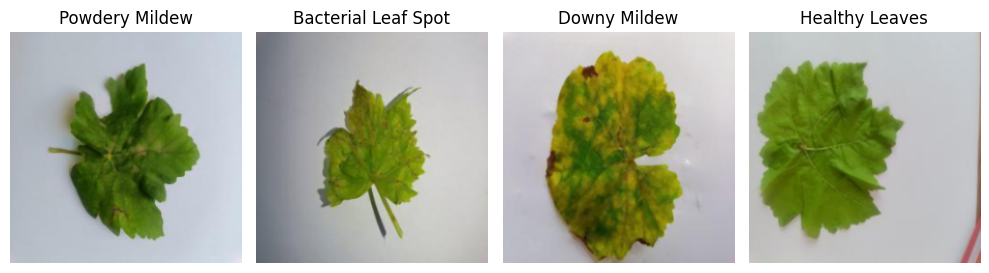

In [22]:
def show_random_images_per_class(root_path):
    class_names = os.listdir(root_path)
    plt.figure(figsize=(10, 5))
    for i, class_name in enumerate(class_names):
        class_path = os.path.join(root_path, class_name)
        image_path = random.choice(glob(os.path.join(class_path, '*')))
        img = preprocess_image(image_path)
        plt.subplot(1, 4, i + 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(class_name)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_random_images_per_class(train_path)

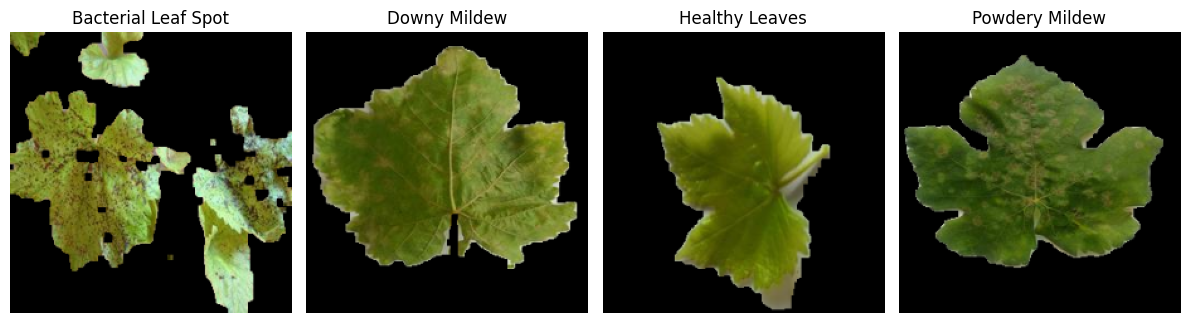

In [23]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from glob import glob

#  Background removal using HSV + black background
def remove_leaf_background_black(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Convert to HSV
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    # Define mask range for green leaves
    lower = np.array([25, 40, 40])
    upper = np.array([90, 255, 255])
    mask = cv2.inRange(hsv, lower, upper)

    # Clean the mask
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

    # Apply black background
    result = cv2.bitwise_and(img, img, mask=mask)
    background = np.zeros_like(img)
    final = np.where(mask[:, :, None] == 255, result, background)

    return final

#  Show 1 random processed image per class
def show_random_images_per_class(root_path):
    class_dirs = sorted(os.listdir(root_path))
    plt.figure(figsize=(12, 4))
    
    for i, class_name in enumerate(class_dirs[:4]):  # Just 4 classes
        class_path = os.path.join(root_path, class_name)
        img_path = random.choice(glob(os.path.join(class_path, '*')))
        
        result = remove_leaf_background_black(img_path)
        result = cv2.resize(result, (224, 224))

        plt.subplot(1, 4, i + 1)
        plt.imshow(result)
        plt.title(class_name)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# 🔍 Dataset folder path
train_path = "/kaggle/input/grape-leaf/Niphad Grape Leaf Disease Dataset (NGLD)/Grapes Disease Dataset train"

#  Show the processed images
show_random_images_per_class(train_path)


In [37]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [28]:
# =============== Train Model ======================

history = model.fit(
    train_generator,
    validation_data=val_generator,
    
    epochs=20
)

# =============== Evaluate Model ===================

y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred_classes, target_names=class_labels))


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1751381650.588997     130 service.cc:148] XLA service 0x7f2a38008c80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751381650.589877     130 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1751381650.589900     130 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1751381650.926408     130 cuda_dnn.cc:529] Loaded cuDNN version 90300


 2/85 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.2656 - loss: 2.1735 

I0000 00:00:1751381656.214081     130 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


85/85 ━━━━━━━━━━━━━━━━━━━━ 56s 565ms/step - accuracy: 0.4866 - loss: 1.3170 - val_accuracy: 0.7017 - val_loss: 0.7174
Epoch 2/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 37s 435ms/step - accuracy: 0.7214 - loss: 0.7494 - val_accuracy: 0.7335 - val_loss: 0.6340
Epoch 3/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 36s 428ms/step - accuracy: 0.7449 - loss: 0.6599 - val_accuracy: 0.8313 - val_loss: 0.4985
Epoch 4/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 37s 432ms/step - accuracy: 0.7763 - loss: 0.6271 - val_accuracy: 0.8680 - val_loss: 0.4694
Epoch 5/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 36s 427ms/step - accuracy: 0.8030 - loss: 0.5262 - val_accuracy: 0.7531 - val_loss: 0.5954
Epoch 6/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 37s 439ms/step - accuracy: 0.8244 - loss: 0.5021 - val_accuracy: 0.8875 - val_loss: 0.3831
Epoch 7/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 37s 429ms/step - accuracy: 0.8342 - loss: 0.4713 - val_accuracy: 0.9046 - val_loss: 0.2887
Epoch 8/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 36s 423ms/step - accuracy: 0.8475 - loss: 0.4083 - val_accuracy: 0.887

In [35]:
#  Final training and validation accuracy from training history
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]

print(f" Final Training Accuracy: {final_train_acc:.4f}")
print(f" Final Validation Accuracy: {final_val_acc:.4f}")

#  Evaluate on test set
test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)
print(f" Final Test Accuracy: {test_accuracy:.4f}")



 Final Training Accuracy: 0.9351
 Final Validation Accuracy: 0.9682
 Final Test Accuracy: 0.9389


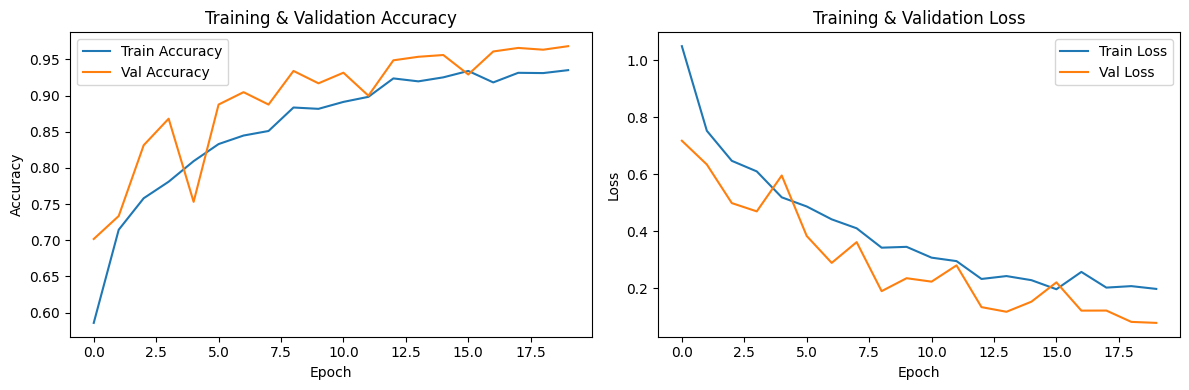

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step

Classification Report:
                     precision    recall  f1-score   support

Bacterial Leaf Spot       0.92      0.80      0.86        15
       Downy Mildew       0.94      0.89      0.91       145
     Healthy Leaves       0.93      0.99      0.96       188
     Powdery Mildew       0.97      0.92      0.94        61

           accuracy                           0.94       409
          macro avg       0.94      0.90      0.92       409
       weighted avg       0.94      0.94      0.94       409



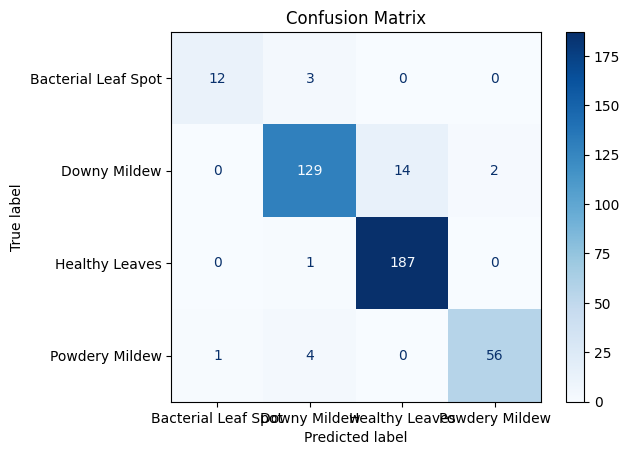

In [33]:



# =============== Plot Accuracy and Loss ==============
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

# =============== Predict and Evaluate on Test Set ==============
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
